# __Project Group 3:__ 
# __Fake News Classification using Natural Language Processing (NLP)__

## Model Development

### Import and Initialisation of Libaries


In [148]:
import pandas as pd
import numpy as np
import re

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/paulmuller/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/paulmuller/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/paulmuller/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/paulmuller/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/paulmuller/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Preparation of Dataset


In [149]:
# Load the data
data_file = "training_data_lowercase.csv"
data = pd.read_csv(data_file, sep="\t", header=None)  # Load as tab-delimited file without headers

data.describe

<bound method NDFrame.describe of        0                                                  1
0      0  donald trump sends out embarrassing new year‚s...
1      0  drunk bragging trump staffer started russian c...
2      0  sheriff david clarke becomes an internet joke ...
3      0  trump is so obsessed he even has obama‚s name ...
4      0  pope francis just called out donald trump duri...
...   ..                                                ...
34147  1  tears in rain as thais gather for late king's ...
34148  1  pyongyang university needs non-u.s. teachers a...
34149  1  philippine president duterte to visit japan ah...
34150  1  japan's abe may have won election\tbut many do...
34151  1  demoralized and divided: inside catalonia's po...

[34152 rows x 2 columns]>

In [150]:
# Assign new column names
data.columns = ['label', 'text']

# Enhanced display with pandas styling
data.head(10).style.set_properties(**{'text-align': 'left'}).set_table_styles(
    [{'selector': 'th', 'props': [('text-align', 'left')]}])

### Preprocessing of Dataset


In [151]:
# Remove special characters
data['text'] = data['text'].str.replace(r'[^a-z0-9\s]', '', regex=True)

In [152]:
# Define a set of common English stopwords using NLTK's predefined list.
stop_words = set(stopwords.words('english'))

In [153]:
# Tokenize and remove stopwords for each text entry in the dataframe
data['filtered_text'] = data['text'].apply(lambda x: [word for word in word_tokenize(x) if word.lower() not in stop_words])

In [154]:
# Lemmatization of text to leverage the context as well

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to get part-of-speech (POS) tagging for more accurate lemmatization
def get_wordnet_pos(word):
    from nltk.corpus import wordnet
    from nltk import pos_tag
    tag = pos_tag([word])[0][1][0].upper()
    tag_dict = {
        'J': wordnet.ADJ,  # Adjective
        'N': wordnet.NOUN,  # Noun
        'V': wordnet.VERB,  # Verb
        'R': wordnet.ADV   # Adverb
    }
    return tag_dict.get(tag, wordnet.NOUN)  # Default to noun

# Apply lemmatization to the filtered_text column
data['lemmatized_text'] = data['filtered_text'].apply(
    lambda tokens: [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in tokens]
)

# Display the first few rows to verify the result
print(data.head())



   label                                               text  \
0      0  donald trump sends out embarrassing new years ...   
1      0  drunk bragging trump staffer started russian c...   
2      0  sheriff david clarke becomes an internet joke ...   
3      0  trump is so obsessed he even has obamas name c...   
4      0  pope francis just called out donald trump duri...   

                                       filtered_text  \
0  [donald, trump, sends, embarrassing, new, year...   
1  [drunk, bragging, trump, staffer, started, rus...   
2  [sheriff, david, clarke, becomes, internet, jo...   
3  [trump, obsessed, even, obamas, name, coded, w...   
4  [pope, francis, called, donald, trump, christm...   

                                     lemmatized_text  
0  [donald, trump, sends, embarrass, new, year, e...  
1  [drunk, bragging, trump, staffer, start, russi...  
2  [sheriff, david, clarke, becomes, internet, jo...  
3  [trump, obsess, even, obamas, name, cod, websi...  
4  [pope,

In [155]:
# Combine tokens into single text strings for each row in 'lemmatized_text'
data['lemmatized_text'] = data['lemmatized_text'].apply(lambda tokens: ' '.join(tokens))

print(data['lemmatized_text'])

0        donald trump sends embarrass new year eve mess...
1        drunk bragging trump staffer start russian col...
2        sheriff david clarke becomes internet joke thr...
3          trump obsess even obamas name cod website image
4          pope francis call donald trump christmas speech
                               ...                        
34147              tear rain thai gather late king funeral
34148    pyongyang university need nonus teacher travel...
34149    philippine president duterte visit japan ahead...
34150             japan abe may election many dont want pm
34151      demoralize divide inside catalonia police force
Name: lemmatized_text, Length: 34152, dtype: object


In [156]:
# Display summary statistics of the lengths of lemmatized text entries to understand the distribution of text size
print(data['lemmatized_text'].apply(len).describe())

count    34152.000000
mean        59.053994
std         17.685429
min          0.000000
25%         49.000000
50%         57.000000
75%         67.000000
max        229.000000
Name: lemmatized_text, dtype: float64


### Modell Architecture and Training


In [157]:
# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features=10000,  
    stop_words='english',  # Exclude common stopwords 
    ngram_range=(1, 2)  # Consider unigrams and bigrams 
)

In [158]:
# Fit and transform the lemmatized text column
tfidf_matrix = tfidf_vectorizer.fit_transform(data['lemmatized_text'])

In [159]:
# Convert the resulting sparse matrix to a DataFrame for analysis
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

In [160]:
# Display the first few rows of the TF-IDF DataFrame
tfidf_df.head().style.set_properties(**{'text-align': 'left'}).set_table_styles(
    [{'selector': 'th', 'props': [('text-align', 'left')]}])

In [161]:
X = tfidf_df  # Feature set
y = data['label']  

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [162]:
# Train Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

### Model Prediction and Evaluation

In [163]:
# Predict and evaluate
y_pred_lr = log_reg.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Classification Report:\n", classification_report(y_test, y_pred_lr))

Logistic Regression Accuracy: 0.9285609720392329
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.92      0.93      3529
           1       0.92      0.94      0.93      3302

    accuracy                           0.93      6831
   macro avg       0.93      0.93      0.93      6831
weighted avg       0.93      0.93      0.93      6831



In [164]:
# Count and display the number of missing (NaN) values in the 'lemmatized_text' column to check data completeness
print("Number of NaN values:", data['lemmatized_text'].isna().sum())

Number of NaN values: 0


### Visualisation

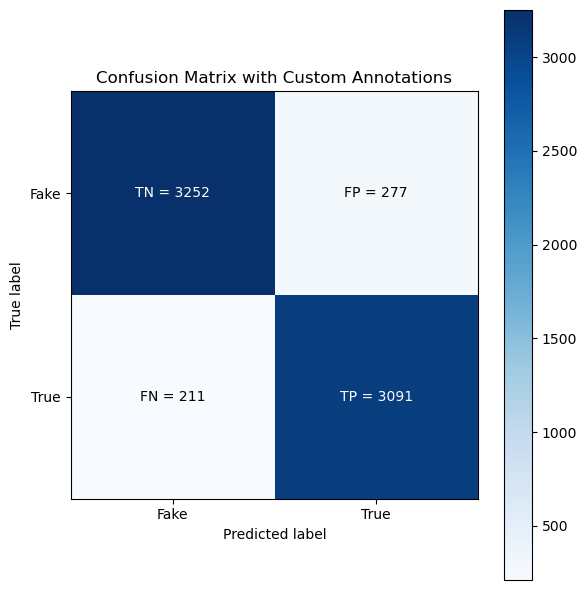

In [165]:
import matplotlib.pyplot as plt
import numpy as np

# Example confusion matrix (replace with your actual matrix)
cm = np.array([[3252, 277],
               [211, 3091]])

# Extract values
tn, fp, fn, tp = cm.ravel()

# Create the plot
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(cm, interpolation='nearest', cmap='Blues')

# Add colorbar
plt.colorbar(im, ax=ax)

# Define class labels
class_labels = ['Fake', 'True']

# Add tick labels
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=class_labels, yticklabels=class_labels,
       ylabel="True label", xlabel="Predicted label")

# Annotate each cell with TP, TN, FP, FN
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        text = f"TN = {tn}" if (i, j) == (0, 0) else \
               f"FP = {fp}" if (i, j) == (0, 1) else \
               f"FN = {fn}" if (i, j) == (1, 0) else \
               f"TP = {tp}"
        ax.text(j, i, text, ha="center", va="center", color="white" if cm[i, j] > cm.max() / 2 else "black")

# Add title
plt.title("Confusion Matrix with Custom Annotations")
plt.tight_layout()
plt.show()


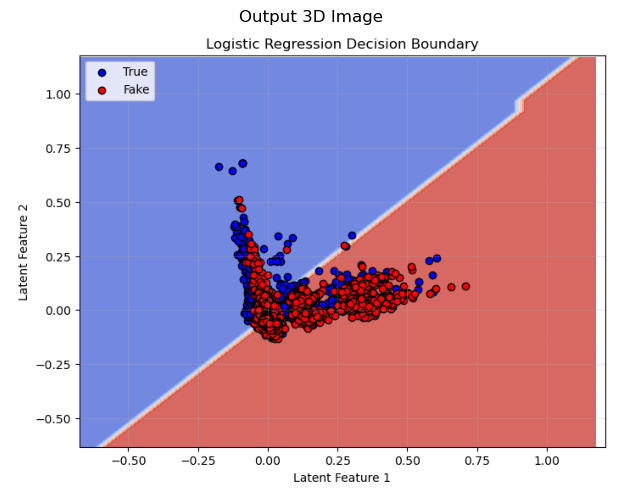

In [166]:
# This code is for ploting the 3D model, but it stops the prediction of the testdata from running / thats why we just plot the image in the code.

"""import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from matplotlib.colors import LinearSegmentedColormap

# Perform PCA for visualization (reduce to 2 components)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)  # PCA transformation for training data
X_test_pca = pca.transform(X_test)  # PCA transformation for test data

# Train Logistic Regression on PCA-reduced data
log_reg.fit(X_pca, y_train)

# Predict on PCA-reduced test data
y_pred_test = log_reg.predict(X_test_pca)  # This ensures test predictions work

# Create a mesh grid for decision boundary
x_min, x_max = X_pca[:, 0].min() - 0.5, X_pca[:, 0].max() + 0.5
y_min, y_max = X_pca[:, 1].min() - 0.5, X_pca[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05),
                     np.arange(y_min, y_max, 0.05))

# Predict over the grid using PCA-reduced space
Z = log_reg.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Define a custom colormap
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', ['blue', 'red'], N=256)

# Plot the decision boundary
plt.figure(figsize=(6, 6))
plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)

# Plot data points with labels for legend
class_0 = plt.scatter(X_pca[y_train == 0, 0], X_pca[y_train == 0, 1],
                      c='blue', edgecolors='k', label='True')
class_1 = plt.scatter(X_pca[y_train == 1, 0], X_pca[y_train == 1, 1],
                      c='red', edgecolors='k', label='Fake')

# Add plot details
plt.title("Logistic Regression Decision Boundary")
plt.xlabel("Latent Feature 1")
plt.ylabel("Latent Feature 2")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.grid(alpha=0.3)
plt.legend(loc='upper left')
plt.show()

# Display test predictions (example output)
print("Predictions for test data:", y_pred_test)"""


# for ploting the image of the 3D
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load and display the image
image_path = "./Archive/output_3d.png"  # Replace with the correct relative or absolute path
img = mpimg.imread(image_path)
plt.figure(figsize=(8, 6))
plt.imshow(img)
plt.axis('off')  # Remove axis for a cleaner display
plt.title("Output 3D Image")
plt.show()



## Creating the Testdata Prediction in CSV-File

### Preparation

In [167]:
# Load the testing dataset (update file path accordingly)
testing_data_file = "testing_data_lowercase_nolabels.csv"
testing_data = pd.read_csv(testing_data_file, sep="\t", header=None)  # Tab-separated
testing_data.columns = ['label', 'text']

### Preprocessing

In [168]:
# Remove special characters
testing_data['text'] = testing_data['text'].str.replace(r'[^a-z0-9\s]', '', regex=True)

In [169]:
# Tokenize and remove stopwords for each text entry in the dataframe
testing_data['filtered_text'] = testing_data['text'].apply(lambda x: [word for word in word_tokenize(x) if word.lower() not in stop_words])

In [170]:
# Lemmatization of text to leverage the context as well

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to get part-of-speech (POS) tagging for more accurate lemmatization
def get_wordnet_pos(word):
    from nltk.corpus import wordnet
    from nltk import pos_tag
    tag = pos_tag([word])[0][1][0].upper()
    tag_dict = {
        'J': wordnet.ADJ,  # Adjective
        'N': wordnet.NOUN,  # Noun
        'V': wordnet.VERB,  # Verb
        'R': wordnet.ADV   # Adverb
    }
    return tag_dict.get(tag, wordnet.NOUN)  # Default to noun

# Apply lemmatization to the filtered_text column
testing_data['lemmatized_text'] = testing_data['filtered_text'].apply(
    lambda tokens: [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in tokens]
)

# Display the first few rows to verify the result
print(testing_data.head())

  label                                               text  \
0     2  copycat muslim terrorist arrested with assault...   
1     2  wow chicago protester caught on camera admits ...   
2     2     germanys fdp look to fill schaeubles big shoes   
3     2  mi school sends welcome back packet warning ki...   
4     2  un seeks massive aid boost amid rohingya emerg...   

                                       filtered_text  \
0  [copycat, muslim, terrorist, arrested, assault...   
1  [wow, chicago, protester, caught, camera, admi...   
2  [germanys, fdp, look, fill, schaeubles, big, s...   
3  [mi, school, sends, welcome, back, packet, war...   
4  [un, seeks, massive, aid, boost, amid, rohingy...   

                                     lemmatized_text  
0  [copycat, muslim, terrorist, arrest, assault, ...  
1  [wow, chicago, protester, caught, camera, admi...  
2  [germany, fdp, look, fill, schaeubles, big, shoe]  
3  [mi, school, sends, welcome, back, packet, war...  
4  [un, seek, m

In [171]:
# Combine tokens into single text strings for each row in 'lemmatized_text'
testing_data['lemmatized_text'] = testing_data['lemmatized_text'].apply(lambda tokens: ' '.join(tokens))

print(testing_data['lemmatized_text'])

0          copycat muslim terrorist arrest assault weapon
1       wow chicago protester caught camera admits vio...
2               germany fdp look fill schaeubles big shoe
3       mi school sends welcome back packet warn kid w...
4       un seek massive aid boost amid rohingya emerge...
                              ...                        
9979    boom fox news leftist chris wallace attempt tr...
9980    list democrat hypocrite vote filibuster gw bus...
9981    new fire ravage rohingya village northwest mya...
9982    meal wheel shuts lyin lefty truth moveonorgs f...
9983    brilliant tucker carlson ayaan hirsi ali discu...
Name: lemmatized_text, Length: 9984, dtype: object


### Executing Model on Testdata

In [172]:
# Fit and transform the lemmatized text column
tfidf_matrix_testing = tfidf_vectorizer.transform(testing_data['lemmatized_text'])

In [173]:
# Convert the resulting sparse matrix to a DataFrame for analysis
tfidf_df_testing = pd.DataFrame(tfidf_matrix_testing.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

In [174]:
# Display the first few rows of the TF-IDF DataFrame
print(tfidf_df_testing.head(50))

     10  10 billion  10 day  10 million  10 year  100  100 day  100 million  \
0   0.0         0.0     0.0         0.0      0.0  0.0      0.0          0.0   
1   0.0         0.0     0.0         0.0      0.0  0.0      0.0          0.0   
2   0.0         0.0     0.0         0.0      0.0  0.0      0.0          0.0   
3   0.0         0.0     0.0         0.0      0.0  0.0      0.0          0.0   
4   0.0         0.0     0.0         0.0      0.0  0.0      0.0          0.0   
5   0.0         0.0     0.0         0.0      0.0  0.0      0.0          0.0   
6   0.0         0.0     0.0         0.0      0.0  0.0      0.0          0.0   
7   0.0         0.0     0.0         0.0      0.0  0.0      0.0          0.0   
8   0.0         0.0     0.0         0.0      0.0  0.0      0.0          0.0   
9   0.0         0.0     0.0         0.0      0.0  0.0      0.0          0.0   
10  0.0         0.0     0.0         0.0      0.0  0.0      0.0          0.0   
11  0.0         0.0     0.0         0.0      0.0  0.

In [175]:
X_testing = tfidf_df_testing  # Feature set
y_testing = testing_data['label']  

In [176]:
print(X_testing)

       10  10 billion  10 day  10 million  10 year  100  100 day  100 million  \
0     0.0         0.0     0.0         0.0      0.0  0.0      0.0          0.0   
1     0.0         0.0     0.0         0.0      0.0  0.0      0.0          0.0   
2     0.0         0.0     0.0         0.0      0.0  0.0      0.0          0.0   
3     0.0         0.0     0.0         0.0      0.0  0.0      0.0          0.0   
4     0.0         0.0     0.0         0.0      0.0  0.0      0.0          0.0   
...   ...         ...     ...         ...      ...  ...      ...          ...   
9979  0.0         0.0     0.0         0.0      0.0  0.0      0.0          0.0   
9980  0.0         0.0     0.0         0.0      0.0  0.0      0.0          0.0   
9981  0.0         0.0     0.0         0.0      0.0  0.0      0.0          0.0   
9982  0.0         0.0     0.0         0.0      0.0  0.0      0.0          0.0   
9983  0.0         0.0     0.0         0.0      0.0  0.0      0.0          0.0   

      100 percent  1000  ..

In [177]:
# Predict y
y_pred_lr_testing = log_reg.predict(X_testing)

In [178]:
# checking the results  
print(y_pred_lr_testing)

[0 0 1 ... 1 0 0]


### Writing Model Results in Dataset and Export CSV

In [179]:
# write the predicted labels in the model testing dataset  
testing_data['label'] = y_pred_lr_testing

In [180]:
# check saving label
testing_data.head(10)

label                                               text  \
0      0  copycat muslim terrorist arrested with assault...   
1      0  wow chicago protester caught on camera admits ...   
2      1     germanys fdp look to fill schaeubles big shoes   
3      0  mi school sends welcome back packet warning ki...   
4      1  un seeks massive aid boost amid rohingya emerg...   
5      0  did oprah just leave nasty hillary wishing she...   
6      1  frances macron says his job not cool cites tal...   
7      0  flashback chilling 60 minutes interview with g...   
8      1  spanish foreign ministry says to expel north k...   
9      1  trump says cuba did some bad things aimed at u...   

                                       filtered_text  \
0  [copycat, muslim, terrorist, arrested, assault...   
1  [wow, chicago, protester, caught, camera, admi...   
2  [germanys, fdp, look, fill, schaeubles, big, s...   
3  [mi, school, sends, welcome, back, packet, war...   
4  [un, seeks, massive, aid, boost, amid, rohingy...   
5  [oprah, leave, nasty, hillary, wishing, wouldn...   
6  [frances, macron, says, job, cool, cites, talk...   
7  [flashback, chilling, 60, minutes, interview, ...   
8  [spanish, foreign, ministry, says, expel, nort...   
9  [trump, says, cuba, bad, things, aimed, us, di...   

                                     lemmatized_text  
0     copycat muslim terrorist arrest assault weapon  
1  wow chicago protester caught camera admits vio...  
2          germany fdp look fill schaeubles big shoe  
3  mi school sends welcome back packet warn kid w...  
4  un seek massive aid boost amid rohingya emerge...  
5  oprah leave nasty hillary wish wouldnt endorse...  
6  france macron say job cool cite talk turkey er...  
7  flashback chill 60 minute interview george sor...  
8  spanish foreign ministry say expel north korea...  
9            trump say cuba bad thing aim u diplomat

In [181]:
# cleaning the dataset 
testing_data = testing_data[['label', 'text']]
testing_data.head()

label                                               text
0      0  copycat muslim terrorist arrested with assault...
1      0  wow chicago protester caught on camera admits ...
2      1     germanys fdp look to fill schaeubles big shoes
3      0  mi school sends welcome back packet warning ki...
4      1  un seeks massive aid boost amid rohingya emerg...

In [182]:
# Save the modified testing dataset to a new CSV file
testing_data.to_csv("testing_data_lowercase_nolabels_G3.csv", index=False, sep="\t", header=False)